# Particle Swarm Optimisation
Dropwave Function F5 on range [-100, 100] with Particla Swarm Optimisation (PSO).

Copyright (c) 2023, Imam Ilham Khawarizma
Telkom University: Informatics - NIM: 1301180436

In [24]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool



In [25]:
# Define the F5 dropwave function
def F5(x):
    x = np.array(x)
    dim = len(x)
    return sum(100 * (x[1:dim] - x[0:dim-1]**2)**2 + (x[0:dim-1] - 1)**2)


In [26]:
class Particle():
    def __init__(self, dim, lb, ub, Vmax, bounded=False):
        '''A single particle part of the swarm.
        :param dim: int, dimension of the search space
        :param lb: (dim, ) numpy array, lower bound of the search space
        :param ub: (dim, ) numpy array, upper bound of the search space
        :param Vmax: double, Maximum allowed velocity of the particle
        '''
        self.position = np.random.uniform(low=lb, high=ub)
        self.velocity = np.random.uniform(low=0, high=Vmax, size=dim)
        self.dim, self.lb, self.ub, self.Vmax = dim, lb, ub, Vmax
        self.pbest_pos = self.position.copy()
        self.pbest_value = np.inf
        self.bounded = bounded
        
    def update_pos(self):
        '''Update the particle position based on velocity.
        The position can be bounded if self.bounded is True. If position goes
        out of bound, it is set to the boudn and the velocity sign is inversed.
        '''
        self.position += self.velocity
        if self.bounded:
            out_below = self.position<self.lb
            out_above = self.position>self.ub
            self.position[out_below] = self.lb[out_below]
            self.velocity[out_below] *= -1
            self.position[out_above] = self.ub[out_above]
            self.velocity[out_above] *= -1


    def update_pbest(self, cost):
        if cost < self.pbest_value:
            self.pbest_value = cost
            self.pbest_pos = self.position.copy()

In [27]:
class PSO():
    def __init__(self, cost_fn, n_particles, dim, lb, ub, Vmax=None, inertial_weight=0.5, self_conf=0.8, swarm_conf=0.9, n_iter=500, target=None, target_error=1e-6, bounded=False, n_jobs=1):
        '''Wrapper for running particle swarm optimization
        :param cost_fn: function which returns the cost to be optimized for one input
        :param n_particles: numebr of aprticles to use in PSO
        :param dim: int, dimension of the search space
        :param lb: (dim, ) numpy array, lower bound of the search space
        :param ub: (dim, ) numpy array, upper bound of the search space
        :param Vmax: double, Maximum allowed velocity of the particle. Default inf
        :param inertial_weight: float, hyperparameter determining the effect of the velocity on next iteration. Default 0.5
        :param self_conf: float, C1 hyperparameter self-confidence. Default 0.8
        :param swarm_conf: float, C2 hyperparameter swarm-confidence. Default 0.9
        :param n_iter: int, number of iterations of PSO to run. Default = 500
        :param target: float, target minimum value to achieve. Default is None
        :param target_error: float, stopping criterion if given target value
        :param bounded: bool, if True, the positions are kept within lb and ub. If false, lb and ub only used for particle initialization
        :param n_jobs: int, number of parallel jobs to run. default=1 (no parallel processing). To use all cores, n_jobs=-1
        '''
        lb, ub = np.array(lb), np.array(ub)
        assert lb.shape[0] == dim and ub.shape[0] == dim
        if Vmax is None: Vmax = np.max(ub)
        self.particles = [Particle(dim, lb, ub, Vmax, bounded=bounded) for _ in range(n_particles)]
        self.cost_fn = cost_fn
        self.gbest_pos = np.random.uniform(low=lb, high=ub)
        self.gbest_value = np.inf
        self.Vmax, self.w, self.C1, self.C2 = Vmax, inertial_weight, self_conf, swarm_conf
        self.max_iter, self.target, self.target_error = n_iter, target, target_error
        self.lb, self.ub = lb, ub

        if n_jobs==-1:
            self.n_jobs = cpu_count()
        else:
            self.n_jobs = n_jobs
        self.pool = ThreadPool(self.n_jobs)
        
    def __del__(self):
        self.pool.close()

    def update_pbest(self, p: Particle):
        '''Update the local best solution of a particle
        :param p: Particle object to be updated
        '''
        cost = self.cost_fn(p.position)
        p.update_pbest(cost)
        return cost

    def update_best(self):
        '''Update the global and local best for the set of particles
        '''
        costs = self.pool.map(self.update_pbest, self.particles)
        costs = np.array(costs)
        mincost_id = costs.argmin()
        mincost = costs[mincost_id]
        if mincost < self.gbest_value:
            self.gbest_value = mincost
            self.gbest_pos = self.particles[mincost_id].position.copy()

    def move_part(self, p: Particle):
        ''' Update the velocity of single particle and perform movement
        :param p: Particle object to move
        '''
        phi1, phi2 = np.random.rand(2)
        new_velocity = (self.w*p.velocity) + (self.C1*phi1*(p.pbest_pos - p.position)) + \
                        (self.C2*phi2*(self.gbest_pos-p.position))
        new_velocity[new_velocity<-self.Vmax] = -self.Vmax
        new_velocity[new_velocity>self.Vmax] = self.Vmax
        p.velocity = new_velocity
        p.update_pos()

    def move_particles(self):
        '''Perform velcoity update on all particles
        '''
        self.pool.map(self.move_part, self.particles)

    def run(self):
        '''Run the PSO algorithm
        '''
        n_iter = 0
        while(n_iter < self.max_iter):
            self.update_best()
            if self.target is not None and (abs(self.gbest_value-self.target)<= self.target_error):
                break
            
            self.move_particles()
            n_iter += 1
        return self.gbest_pos, self.gbest_value

    def visualize(self):
        if self.lb.shape[0]!=2: raise Exception('Only 2D cost function can be visualized')
        x_ax = np.linspace(self.lb[0], self.ub[0], num=500)
        y_ax = np.linspace(self.lb[1], self.ub[1], num=500)
        X, Y = np.meshgrid(x_ax, y_ax)
        Z = self.cost_fn([X, Y])
        besthist_x, besthist_y, besthist_val = [], [], []
        n_iter = 0
        while n_iter < self.max_iter:
            # if n_iter%20 == 0:
            besthist_x.append(self.gbest_pos[0])
            besthist_y.append(self.gbest_pos[1])
            besthist_val.append(self.gbest_value)

            self.update_best()
            if self.target is not None and (abs(self.gbest_value-self.target)<= self.target_error):
                break
            
            self.move_particles()
            n_iter += 1

        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(1,2,1)
        contour_plot = ax.contourf(X,Y,Z, 20, cmap='RdGy')
        ax.plot(besthist_x, besthist_y, c='y', linewidth=1)
        xs, ys = [], []
        for p in self.particles:
            xs.append(p.position[0])
            ys.append(p.position[1])
        ax.scatter(xs, ys, c='b', s=3, zorder=1, label='Particles')
        ax.scatter(self.gbest_pos[0], self.gbest_pos[1], c='y', s=10, zorder=2, marker='*', label='Global Best')
        fig.colorbar(contour_plot)
        ax.legend()
        ax.set_title('Cost function')
        ax.set_xlabel('x1')
        ax.set_xlim([self.lb[0], self.ub[0]])
        ax.set_ylim([self.lb[1], self.ub[1]])
        ax.set_ylabel('x2')

        ax2 = fig.add_subplot(1,2,2)
        ax2.plot(besthist_val)
        ax2.set_title('Change in global best value with time')
        ax2.set_xlabel('No. of iterations')
        ax2.set_ylabel('Global optimal')

        fig.show()
        return

In [28]:

    def visualize(self):
        if self.lb.shape[0] != 2:
            raise Exception('Only 2D cost function can be visualized')

        x_ax = np.linspace(self.lb[0], self.ub[0], num=500)
        y_ax = np.linspace(self.lb[1], self.ub[1], num=500)
        X, Y = np.meshgrid(x_ax, y_ax)
        Z = self.cost_fn([X, Y])

        besthist_x, besthist_y, besthist_val = [], [], []
        n_iter = 0

        while n_iter < self.max_iter:
            besthist_x.append(self.gbest_pos[0])
            besthist_y.append(self.gbest_pos[1])
            besthist_val.append(self.gbest_value)

            self.update_best()

            if self.target is not None and (abs(self.gbest_value - self.target) <= self.target_error):
                break

            self.move_particles()
            n_iter += 1

        # Scale function values to [0, 2]
        Z_min = np.min(Z)
        Z_max = np.max(Z)
        Z_scaled = 2.0 * (Z - Z_min) / (Z_max - Z_min)

        fig = plt.figure(figsize=(20, 8))
        ax = fig.add_subplot(1, 2, 1)
        contour_plot = ax.contourf(X, Y, Z_scaled, 20, cmap='RdGy')
        ax.plot(besthist_x, besthist_y, c='y', linewidth=1)
        xs, ys = [], []

        for p in self.particles:
            xs.append(p.position[0])
            ys.append(p.position[1])

        ax.scatter(xs, ys, c='b', s=3, zorder=1, label='Particles')
        ax.scatter(self.gbest_pos[0], self.gbest_pos[1], c='y', s=10, zorder=2, marker='*', label='Global Best')
        fig.colorbar(contour_plot)
        ax.legend()
        ax.set_title('Cost function')
        ax.set_xlabel('x1')
        ax.set_xlim([self.lb[0], self.ub[0]])
        ax.set_ylim([self.lb[1], self.ub[1]])
        ax.set_ylabel('x2')

        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(besthist_val)
        ax2.set_title('Change in global best value with time')
        ax2.set_xlabel('No. of iterations')
        ax2.set_ylabel('Global optimal')

        fig.show()
        return


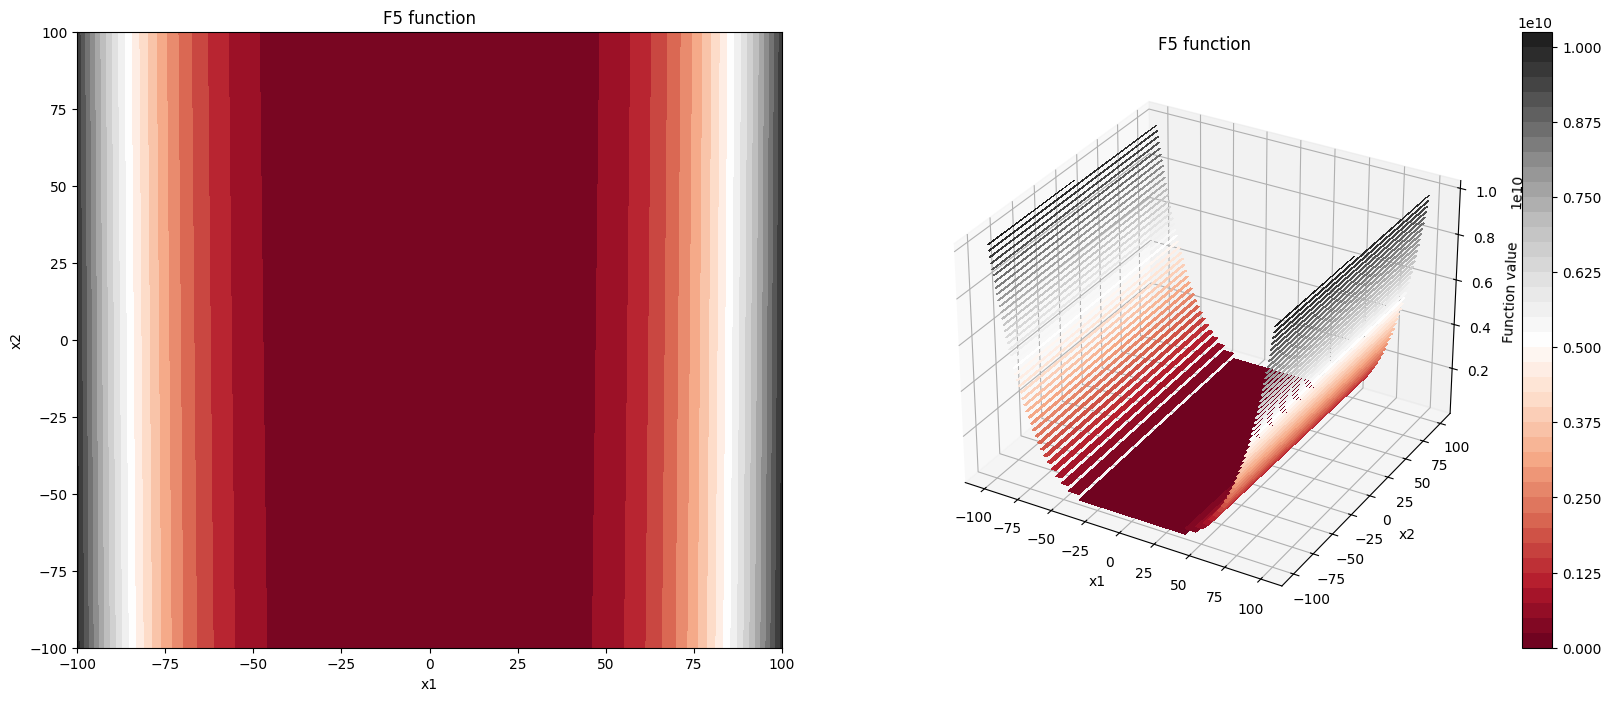

In [29]:
# Set the range and create a meshgrid
x_ax = np.linspace(-100, 100, num=500)
X, Y = np.meshgrid(x_ax, x_ax)

# Evaluate the F5 function
Z = np.zeros_like(X)
for i in range(len(x_ax)):
    for j in range(len(x_ax)):
        Z[i, j] = F5([X[i, j], Y[i, j]])

# Visualize in 2D
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax.contourf(X, Y, Z, 20, cmap='RdGy')
ax.set_title('F5 function')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

# Visualize in 3D
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
mappable = ax2.contourf3D(X, Y, Z, 50, cmap='RdGy')
ax2.set_title('F5 function')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('Function value')
fig.colorbar(mappable)

plt.show()


/var/folders/b5/jhtyfm6n4b17_kdtwj8qrjj00000gn/T/ipykernel_12138/1243850007.py:180: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


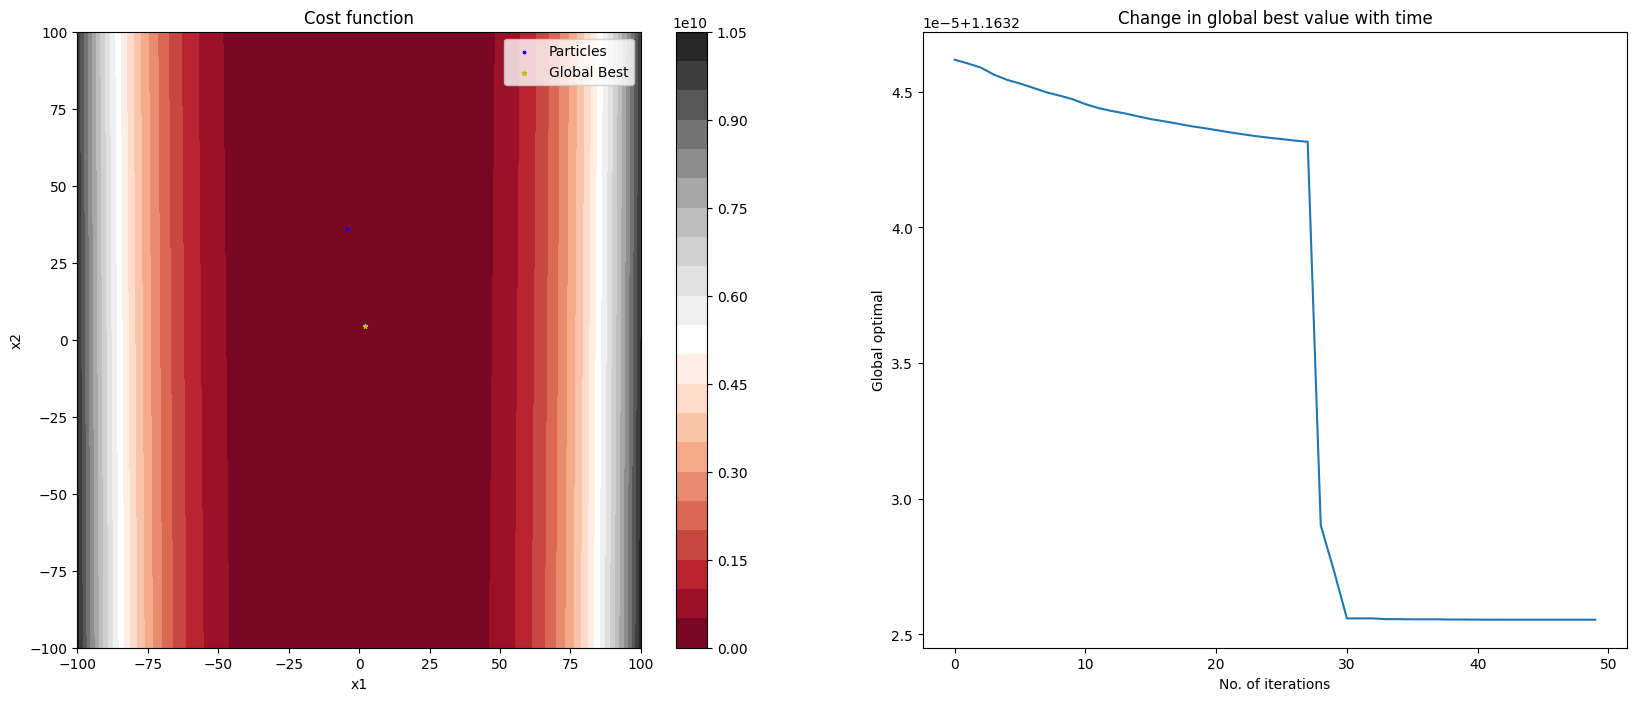

In [30]:
pso.visualize()
plt.show()
